In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
treino = pd.read_csv("train.csv")
teste = pd.read_csv("test.csv")

treino = treino.drop(columns=['media_receita','media_despesa','nome', 'sequencial_candidato'])

In [5]:
numeric_feats = treino.dtypes[treino.dtypes != "object"].index

numeric_feats = numeric_feats.drop('ano')
numeric_feats = numeric_feats.drop('situacao')

treino[numeric_feats] = np.log1p(treino[numeric_feats])

teste[numeric_feats] = np.log1p(teste[numeric_feats])

In [6]:
treino_X = treino.loc[:,:'ocupacao']
treino_Y = treino.loc[:,'situacao']

In [7]:
treino_X = pd.get_dummies(treino_X)

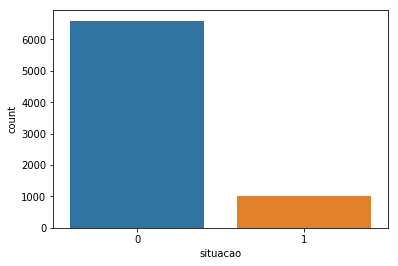

In [8]:
sns.countplot(treino_Y)

É clara a diferença entre a quantidade de instâncias da classe nao_eleito e eleito. Isso pode levar o modelo a aprender de forma errada a classificar os exemplos de teste.

Para balancear as classes usarei a técnica de under-sampling, cluser centroids.

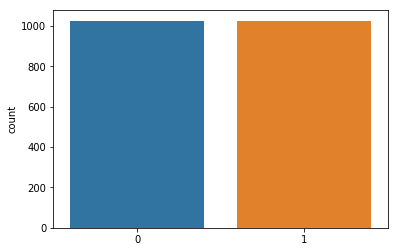

In [9]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids()
x_cc, y_cc = cc.fit_sample(treino_X, treino_Y)
y_cc = y_cc[:,np.newaxis]

sns.countplot(y_cc[:,0])

Com a mesma quantidade de instâncias entre as duas classes, a chance de o modelo sofrer de unerfiting é bem menor.

A seguir inicio o treinamento de alguns modelos a partir dos dados filtrados.

In [10]:
data = np.concatenate((x_cc, y_cc), axis=1)
data = np.random.permutation(data)
x_cc = data[:,0:-1]
y_cc = data[:,-1]

In [11]:
treino_X = np.array(treino_X)
treino_Y = np.array(treino_Y)

Para melhorar a validação dos modelos, utilizo uma fação para fazer uma permutação aleatória nos dados, pois esses ficam agrupados na saída da função de cluster centroids.

In [53]:
from sklearn.model_selection import KFold
from sklearn import metrics

def cv_report(model, predictors, outcome, nfolds):
    
    kf = KFold(n_splits=nfolds)
    f1_score = []
    for train, validation in kf.split(predictors):
        train_predictors = (predictors[train,:])
        train_target =  outcome[train]
        model.fit(train_predictors, train_target)
        
        y = model.predict(predictors[validation,:])
        report = metrics.classification_report(outcome[validation], y, output_dict=True)
        f1_score.append(report['macro avg']['f1-score'])
        
    return np.mean(f1_score)

In [54]:
from sklearn.model_selection import cross_val_score

def f1_cv(model, X, Y, kfolds):
    f1 = cross_val_score(model, X, Y, scoring='f1', cv=kfolds)
    return(f1)

## Regressão Logística

In [67]:
from sklearn.linear_model import LogisticRegression

lambdas = np.arange(0.01,2,0.01).tolist()

cv_logRegression = [f1_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), x_cc, y_cc, 5).mean()
            for lbd in lambdas]
cv_logRegression = pd.Series(cv_logRegression, index = lambdas)

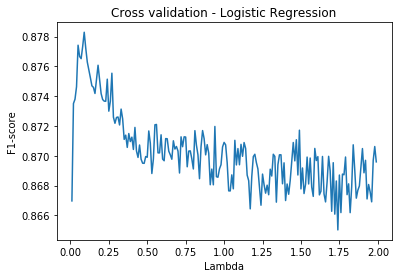

O melhor alpha é 0.09, com F1 = 0.8782952870053855


In [68]:
cv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(cv_logRegression.idxmax(), cv_logRegression.max()))

In [67]:
lgModel = LogisticRegression(solver="lbfgs", max_iter=10000, C=0.09, random_state=1)
lgModel.fit(x_cc,y_cc)

print(metrics.classification_report(treino_Y, lgModel.predict(treino_X), output_dict=True)['macro avg']['f1-score'])

0.826945781491236


In [15]:
from sklearn.linear_model import LogisticRegression
lambdas = np.arange(0.01,2,0.01).tolist()

fullcv_logRegression = [f1_cv(LogisticRegression(solver="lbfgs", max_iter=10000, C=lbd, random_state=1), treino_X, treino_Y, 5).mean()
            for lbd in lambdas]
fullcv_logRegression = pd.Series(fullcv_logRegression, index = lambdas)

NameError: name 'cv_logRegression' is not defined

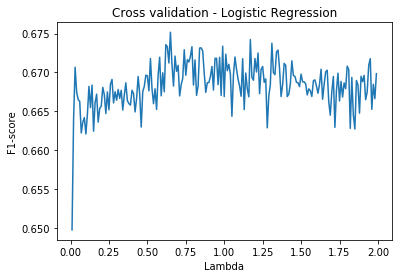

O melhor alpha é 0.65, com F1 = 0.67516386896603


In [16]:
fullcv_logRegression.plot(title = "Cross validation - Logistic Regression")
plt.xlabel("Lambda")
plt.ylabel("F1-score")
plt.show()

print("O melhor alpha é {0}, com F1 = {1}".format(fullcv_logRegression.idxmax(), fullcv_logRegression.max()))

## KNN

In [57]:
from sklearn.neighbors import KNeighborsClassifier

k_list = np.arange(1,100,1).tolist()

cv_knnUnbalanced = [f1_cv(KNeighborsClassifier(n_neighbors = n), treino_X, treino_Y, 5).mean()
            for n in k_list]

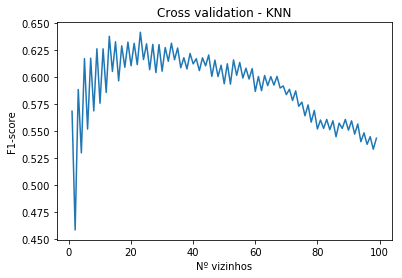

O melhor lambda é 23, com F1-score = 0.6416932630127661


In [58]:
cv_knnUnbalanced = pd.Series(cv_knnUnbalanced, index = k_list)
cv_knnUnbalanced.plot(title = "Cross validation - KNN")
plt.xlabel("Nº vizinhos")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_knnUnbalanced.idxmax(), cv_knnUnbalanced.max()))

In [62]:
k_list = np.arange(1,300,1).tolist()

cv_knnBalanced = [f1_cv(KNeighborsClassifier(n_neighbors = n), x_cc, y_cc, 5).mean()
            for n in k_list]

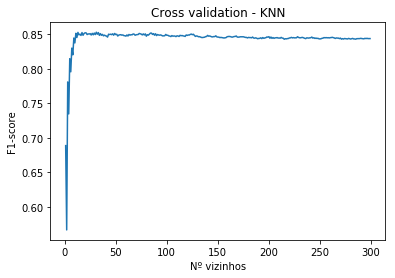

O melhor lambda é 31, com F1-score = 0.8528857510386556


In [63]:
cv_knnBalanced = pd.Series(cv_knnBalanced, index = k_list)
cv_knnBalanced.plot(title = "Cross validation - KNN")
plt.xlabel("Nº vizinhos")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_knnBalanced.idxmax(), cv_knnBalanced.max()))

In [68]:
knnModel = KNeighborsClassifier(n_neighbors=31)
knnModel.fit(x_cc,y_cc)

print("O F1 do modelo "metrics.classification_report(treino_Y, knnModel.predict(treino_X), output_dict=True)['macro avg']['f1-score'])

0.796061385837687


## Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

depth_list = np.arange(1,100,1).tolist()

cv_tree = [f1_cv(DecisionTreeClassifier(max_depth=depth), x_cc, y_cc, 5).mean()
            for depth in depth_list]

In [ ]:
cv_tree = pd.Series(cv_tree, index = depth_list)
cv_tree.plot(title = "Cross validation - Decision tree")
plt.xlabel("Depth")
plt.ylabel("F1-score")
plt.show()

print("O melhor lambda é {0}, com F1-score = {1}".format(cv_tree.idxmax(), cv_tree.max()))

## Random forest

In [88]:
from sklearn.ensemble import RandomForestClassifier

depth_list = np.arange(1,35,1).tolist()

cv_forest = [f1_cv(RandomForestClassifier(max_depth = max_depth, n_estimators=100, random_state=7), x_cc, y_cc, 5).mean()
            for max_depth in depth_list]

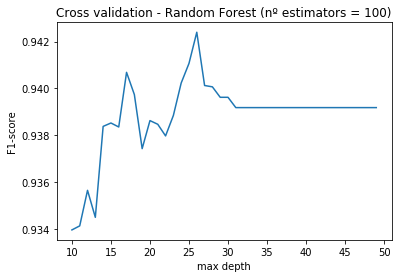

A melhor profundidade (para estimators=100) é 26, com F1 = 0.942395103885422


In [89]:
cv_forest = pd.Series(cv_forest, index = depth_list)
cv_forest.plot(title = "Cross validation - Random Forest (nº estimators = 100)")
plt.xlabel("max depth")
plt.ylabel("F1-score")
plt.show()

print("A melhor profundidade (para estimators=100) é {0}, com F1 = {1}".format(cv_forest.idxmax(), cv_forest.max()))

In [90]:
estimators_list = np.arange(10,500,10).tolist()

cv_forest_dpMin = [f1_cv(RandomForestClassifier(max_depth = cv_forest.idxmax(), n_estimators = n_estimators, random_state=7), x_cc, y_cc, 5).mean()
            for n_estimators in estimators_list]

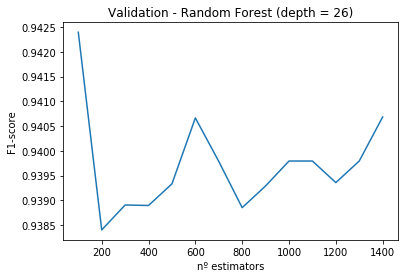

O melhor número de estimators (para profundidade=26) é 100, com rmse = 0.942395103885422


In [91]:
cv_forest_dpMin = pd.Series(cv_forest_dpMin, index = estimators_list)
cv_forest_dpMin.plot(title = "Validation - Random Forest (depth = {0})".format(cv_forest.idxmax()))
plt.xlabel("nº estimators")
plt.ylabel("F1-score")
plt.show()

print("O melhor número de estimators (para profundidade={0}) é {1}, com rmse = {2}".format(cv_forest.idxmax(), cv_forest_dpMin.idxmax(), cv_forest_dpMin.max()))

## Adaboost